In [1]:
%load_ext autoreload
%autoreload
import matplotlib.pyplot as plt
import numpy as np
from phaseco import *
import scipy.io
from scipy.signal import butter, lfilter, sosfilt, freqz, welch

data = 'Old Data'
# data = 'New Data'

if data == 'New Data':
    filepath = "C:\\Users\\Owner\\OneDrive\\Documents\\GitHub\\SOAEpeaks\\Data\\"
    wf_title = 'ACfls27rearSOAEwfD01.txt'
    wf = np.loadtxt(filepath + wf_title)
    fs = 44100
else:
    filepath = r"C:\Users\setht\Dropbox\Citadel\GitHub\phase-coherence\paper_analysis\Data\AC6rearSOAEwfB1.mat"
    mat = scipy.io.loadmat(filepath)
    wf = np.squeeze(mat['wf'])
    fs=44100


In [2]:
# My theory would be that the low frequency stuff is maybe messing with the estimation of the phase at the beginning of each window. 
# Maybe, depending on the length of the window, it can either hurt or help the coherence, leading to the sawtooth pattern

In [7]:
def plot_filter_comparison(tau_ms, xi_ms, cutoff_freq, fftshift_segs=False, filter_plots=True):
    # First the butterworth 
    order = 100
    sos = butter(order, cutoff_freq,'hp',fs=fs,output='sos')
    wf_filt = sosfilt(sos, wf)
    
    # Then the "brute filter"
    def brute_filter(wf, fs, cutoff_freq):
        fft_coefficients = np.fft.rfft(wf)
        frequencies = np.fft.rfftfreq(len(wf), d=1/fs)

        # Zero out coefficients from 0 Hz to cutoff_frequency Hz
        fft_coefficients[frequencies <= cutoff_freq] = 0

        # Compute the inverse real-valued FFT (irfft)
        return np.fft.irfft(fft_coefficients)
    
    wf_brute_filt = brute_filter(wf, fs, cutoff_freq)
    
    if filter_plots:
        # Butterworth Filter
        
        # Generate the impulse response of the filter
        impulse = np.zeros(1000)
        impulse[0] = 1  # Dirac delta impulse
        impulse_response = sosfilt(sos, impulse)

        # Compute the Fourier Transform of the impulse response
        frequency_response = np.fft.fft(impulse_response)
        frequencies = np.fft.fftfreq(len(impulse_response), d=1/fs)

        # Calculate magnitude (in dB) and phase (in degrees)
        magnitude = 20 * np.log10(np.maximum(1e-20, np.abs(frequency_response)))
        phase = np.unwrap(np.angle(frequency_response, deg=False))


        plt.figure(figsize=(18, 6))
        plt.subplot(3, 1, 1)


        # Create the first y-axis (phase)
        ax1 = plt.gca()
        ax1.plot(frequencies[:len(frequencies)//2]/1000, phase[:len(frequencies)//2], color='red', label='Phase [degrees]')
        ax1.set_ylabel('Phase [radians]', color='red')
        ax1.tick_params(axis='y', labelcolor='red')
        ax1.grid(True)
        ax1.set_xlim(0, 7)
        ax1.set_title(f'Magnitude and Phase Response of Butterworth Highpass Filter (order = {order}, cutoff = {cutoff_freq} Hz)')

        # Create the second y-axis (mag)
        ax2 = ax1.twinx()
        ax2.plot(frequencies[:len(frequencies)//2]/1000, magnitude[:len(frequencies)//2], color='blue', label='Magnitude [dB]')
        ax2.set_xlabel('Frequency [kHz]')
        ax2.set_ylabel('Magnitude [dB]', color='blue')
        ax2.tick_params(axis='y', labelcolor='blue')

        # Add legends
        ax1.legend(loc='lower right')
        ax2.legend(loc='center right')
        
        
        # BRUTE FILTER
        plt.subplot(3, 1, 2)
        
        
        # Generate the impulse response of the filter
        impulse = np.zeros(1000)
        impulse[0] = 1  # Dirac delta impulse
        impulse_response = brute_filter(impulse, fs, cutoff_freq)

        # Compute the Fourier Transform of the impulse response
        frequency_response = np.fft.fft(impulse_response)
        frequencies = np.fft.fftfreq(len(impulse_response), d=1/fs)

        # Calculate magnitude (in dB) and phase (in degrees)
        magnitude = 20 * np.log10(np.maximum(1e-20, np.abs(frequency_response)))
        phase = np.unwrap(np.angle(frequency_response, deg=False))

        # Create the first y-axis (phase)
        ax1 = plt.gca()
        ax1.plot(frequencies[:len(frequencies)//2]/1000, phase[:len(frequencies)//2], color='red', label='Phase [degrees]')
        ax1.set_ylabel('Phase [radians]', color='red')
        ax1.tick_params(axis='y', labelcolor='red')
        ax1.grid(True)
        ax1.set_xlim(0, 7)
        ax1.set_title(f'Magnitude and Phase Response of "Brute" Highpass Filter (cutoff = {cutoff_freq} Hz)')

        # Create the second y-axis (mag)
        ax2 = ax1.twinx()
        ax2.plot(frequencies[:len(frequencies)//2]/1000, magnitude[:len(frequencies)//2], color='blue', label='Magnitude [dB]')
        ax2.set_xlabel('Frequency [kHz]')
        ax2.set_ylabel('Magnitude [dB]', color='blue')
        ax2.tick_params(axis='y', labelcolor='blue')
        
        # Add legends
        ax1.legend(loc='lower right')
        ax2.legend(loc='center right')
        plt.subplot(3, 1, 3)


    # Calculate coherence
    tau = round(tau_ms / 1000 * fs)
    xi = round(xi_ms / 1000 * fs)

    win_meth= {'method':'static', 'win_type':'hann'}

    d_lizard_brute_filt = get_autocoherence(wf_brute_filt, fs, win_meth=win_meth, pw=False, tau=tau, xi=xi, ref_type="time", return_dict=True, return_pd=True)
    coherence_brute_filt = d_lizard_brute_filt["autocoherence"]
    pds_brute_filt = d_lizard_brute_filt["pds"]
    f_brute_filt = d_lizard_brute_filt["f"]

    d_lizard_filt = get_autocoherence(wf_filt, fs, win_meth=win_meth, pw=False, tau=tau, xi=xi, ref_type="time", return_dict=True, return_pd=True)
    coherence_filt = d_lizard_filt["autocoherence"]
    pds_filt = d_lizard_filt["pds"]
    f_filt = d_lizard_filt["f"]

    d_lizard = get_autocoherence(wf, fs, win_meth=win_meth, pw=False, tau=tau, xi=xi, ref_type="time", return_dict=True, return_pd=True)
    coherence = d_lizard["autocoherence"]
    pds = d_lizard["pds"]
    f = d_lizard["f"]

    f_psd, psd_lizard = welch(wf, fs, nperseg=tau)
    
    ax1=plt.gca()
    ax1.set_title(r"$C_{\xi}$ with "+ r"$\tau$ = " + f"{tau_ms:.2f}ms, " + r"$\xi$ = " + f"{xi_ms:.2f}ms, Cutoff = {cutoff_freq}Hz", fontsize=20)
    ax1.set_ylabel("Vector Strength", fontsize=18)
    ax1.set_xlabel("Frequency (kHz)", fontsize=18)
    ax1.plot(f/1000, coherence, label = 'Unfiltered')
    ax1.plot(f/1000, coherence_brute_filt, label = '"Brute" Filtered')
    ax1.plot(f/1000, coherence_filt, label = 'Butterworth Filtered')
    ax1.set_ylim(0, 1)
    ax1.legend()
    ax2 = ax1.twinx()
    ax2.plot(f_psd/1000, 10*np.log10(psd_lizard), label ='PSD', color='red')
    ax2.set_ylabel("PSD (dB)")
    ax2.legend(loc='upper right')
    ax2.set_xlim(0, 7)
    ax2.set_ylim(-110, -85)

Demodulating
Demodulating
Demodulating
Demodulating
Demodulating
Demodulating


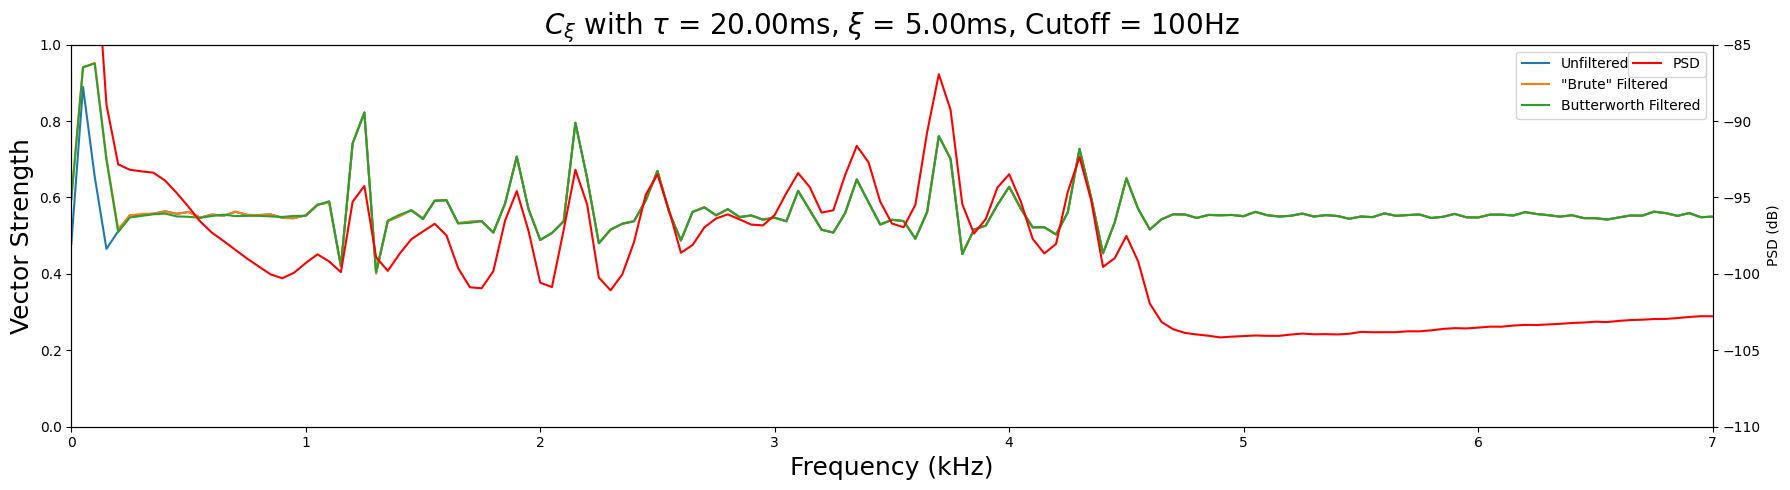

In [8]:
tau_ms=20
xi_ms=5
cutoffs = [100]
n_plots = len(cutoffs)
plt.figure(figsize=(18, 5*n_plots))
i = 0
for cutoff_freq in cutoffs:
    i+=1
    plt.subplot(n_plots, 1, i)
    plot_filter_comparison(tau_ms, xi_ms, cutoff_freq, filter_plots=False)
plt.tight_layout()
plt.show()

TypeError: plot_filter_comparison() missing 1 required positional argument: 'cutoff_freq'

<Figure size 1800x1200 with 0 Axes>

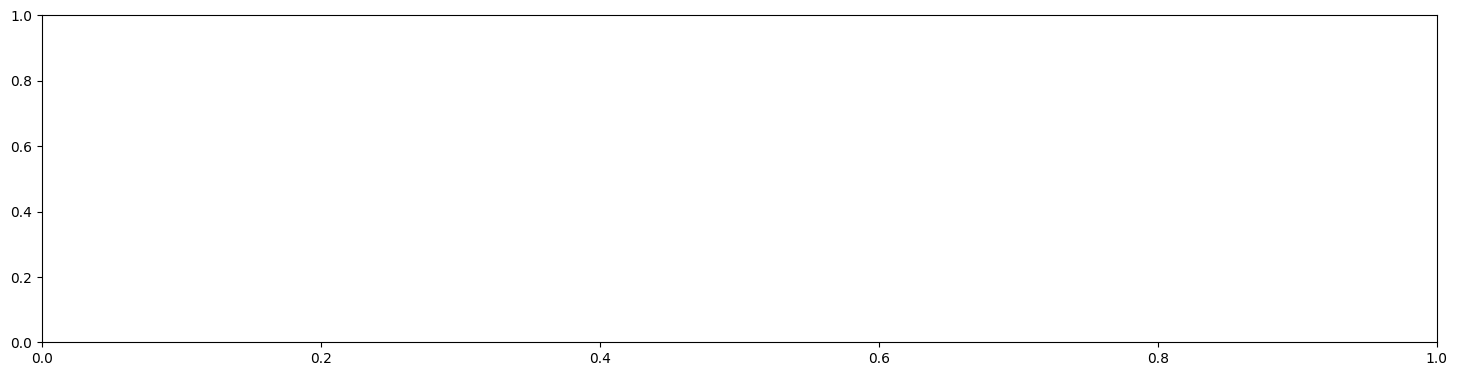

In [5]:
plt.figure(figsize=(18, 12))
taus = [20, 50, 100]
xis = [5, 10, 20]
n_plots = len(xis) * len(taus)
plt.figure(figsize=(18, 5*n_plots))
i = 0
for tau_s in taus: 
    for xi_s in xis:
        i+=1
        plt.subplot(n_plots, 1, i)
        plot_filter_comparison(tau_s, xi_s, filter_plots=False)
plt.tight_layout()
plt.show()

In [ ]:
# Now try filtering seg by seg, I bet it doesn't change the coherence at high freqs anymore!

from scipy.signal import welch



def plot_filter_seg_comparison(tau, xi, cutoff_freq, fftshift_segs=False, filter_plots=False):
    
    if filter_plots:
        # Butterworth Filter
        
        # Generate the impulse response of the filter
        impulse = np.zeros(1000)
        impulse[0] = 1  # Dirac delta impulse
        impulse_response = sosfilt(sos, impulse)

        # Compute the Fourier Transform of the impulse response
        frequency_response = np.fft.fft(impulse_response)
        frequencies = np.fft.fftfreq(len(impulse_response), d=1/fs)

        # Calculate magnitude (in dB) and phase (in degrees)
        magnitude = 20 * np.log10(np.maximum(1e-20, np.abs(frequency_response)))
        phase = np.unwrap(np.angle(frequency_response, deg=False))


        plt.figure(figsize=(18, 6))
        plt.subplot(3, 1, 1)


        # Create the first y-axis (phase)
        ax1 = plt.gca()
        ax1.plot(frequencies[:len(frequencies)//2]/1000, phase[:len(frequencies)//2], color='red', label='Phase [degrees]')
        ax1.set_ylabel('Phase [radians]', color='red')
        ax1.tick_params(axis='y', labelcolor='red')
        ax1.grid(True)
        ax1.set_xlim(0, 7)
        ax1.set_title(f'Magnitude and Phase Response of Butterworth Highpass Filter (order = {order}, cutoff = {cutoff_freq} Hz)')

        # Create the second y-axis (mag)
        ax2 = ax1.twinx()
        ax2.plot(frequencies[:len(frequencies)//2]/1000, magnitude[:len(frequencies)//2], color='blue', label='Magnitude [dB]')
        ax2.set_xlabel('Frequency [kHz]')
        ax2.set_ylabel('Magnitude [dB]', color='blue')
        ax2.tick_params(axis='y', labelcolor='blue')

        # Add legends
        ax1.legend(loc='lower right')
        ax2.legend(loc='center right')
        
        
        # BRUTE FILTER
        plt.subplot(3, 1, 2)
        
        
        # Generate the impulse response of the filter
        impulse = np.zeros(1000)
        impulse[0] = 1  # Dirac delta impulse
        impulse_response = brute_filter(impulse, fs, cutoff_freq)

        # Compute the Fourier Transform of the impulse response
        frequency_response = np.fft.fft(impulse_response)
        frequencies = np.fft.fftfreq(len(impulse_response), d=1/fs)

        # Calculate magnitude (in dB) and phase (in degrees)
        magnitude = 20 * np.log10(np.maximum(1e-20, np.abs(frequency_response)))
        phase = np.unwrap(np.angle(frequency_response, deg=False))

        # Create the first y-axis (phase)
        ax1 = plt.gca()
        ax1.plot(frequencies[:len(frequencies)//2]/1000, phase[:len(frequencies)//2], color='red', label='Phase [degrees]')
        ax1.set_ylabel('Phase [radians]', color='red')
        ax1.tick_params(axis='y', labelcolor='red')
        ax1.grid(True)
        ax1.set_xlim(0, 7)
        ax1.set_title(f'Magnitude and Phase Response of "Brute" Highpass Filter (cutoff = {cutoff_freq} Hz)')

        # Create the second y-axis (mag)
        ax2 = ax1.twinx()
        ax2.plot(frequencies[:len(frequencies)//2]/1000, magnitude[:len(frequencies)//2], color='blue', label='Magnitude [dB]')
        ax2.set_xlabel('Frequency [kHz]')
        ax2.set_ylabel('Magnitude [dB]', color='blue')
        ax2.tick_params(axis='y', labelcolor='blue')
        
        # Add legends
        ax1.legend(loc='lower right')
        ax2.legend(loc='center right')
        plt.subplot(3, 1, 3)


    # Calculate coherence
    tau = tau / 1000
    xi = xi / 1000
    
    def brute_filter(wf, fs, cutoff_freq):
        fft_coefficients = np.fft.rfft(wf)
        frequencies = np.fft.rfftfreq(len(wf), d=1/fs)

        # Zero out coefficients from 0 Hz to cutoff_frequency Hz
        fft_coefficients[frequencies <= cutoff_freq] = 0

        # Compute the inverse real-valued FFT (irfft)
        return np.fft.irfft(fft_coefficients)

    f, coherence_brute_filt = get_autocoherence(wf, fs, tau=tau, xi=xi, win_meth=win_meth, ref_type="time", fftshift_segs=fftshift_segs, filter_seg='brute')

    f, coherence = get_autocoherence(wf, fs, tau=tau, xi=xi, win_meth=win_meth, ref_type="time", fftshift_segs=fftshift_segs, filter_seg=False)
    
    wf_brute_filt = brute_filter(wf, fs, cutoff_freq)
    
    f, coherence_brute_filt_full_signal = get_autocoherence(wf_brute_filt, fs, tau=tau, xi=xi, win_meth=win_meth, ref_type="time", fftshift_segs=fftshift_segs, filter_seg=False)

    f_psd, psd_lizard = welch(wf, fs, nperseg=int(tau*fs))
    f_psd_brute, psd_lizard_brute = welch(wf_brute_filt, fs, nperseg=int(tau*fs))
    
    ax1=plt.gca()
    ax1.set_title(r"$C_{\xi}$ with "+ r"$\tau$ = " + f"{tau*1000:.2f}ms, " + r"$\xi$ = " + f"{xi*1000:.2f}ms, Cutoff = {cutoff_freq}Hz", fontsize=20)
    ax1.set_ylabel("Vector Strength", fontsize=18)
    ax1.set_xlabel("Frequency (kHz)", fontsize=18)
    ax1.plot(f/1000, coherence, label = 'Unfiltered', lw=1, zorder=4)
    ax1.plot(f/1000, coherence_brute_filt, label = '"Brute" Segment Filtered', color='green', lw=3, zorder=3, alpha=0.5)
    ax1.plot(f/1000, coherence_brute_filt_full_signal, label = '"Brute" Full Signal Filtered', color='purple', zorder=1)
    
    
    ax1.set_ylim(0, 1)
    ax1.legend()
    ax2 = ax1.twinx()
    ax2.plot(f_psd/1000, 10*np.log10(psd_lizard), label ='PSD', color='red', lw=1, alpha=0.5, zorder=2)
    ax2.plot(f_psd_brute/1000, psd_lizard_brute, label ='Filtered PSD', color='orange', lw=1, zorder=2)
    ax2.set_ylabel("PSD (dB)")
    ax2.legend(loc='lower right')
    ax2.set_xlim(0, 7)
    ax2.set_ylim(-110, -80)
    
    

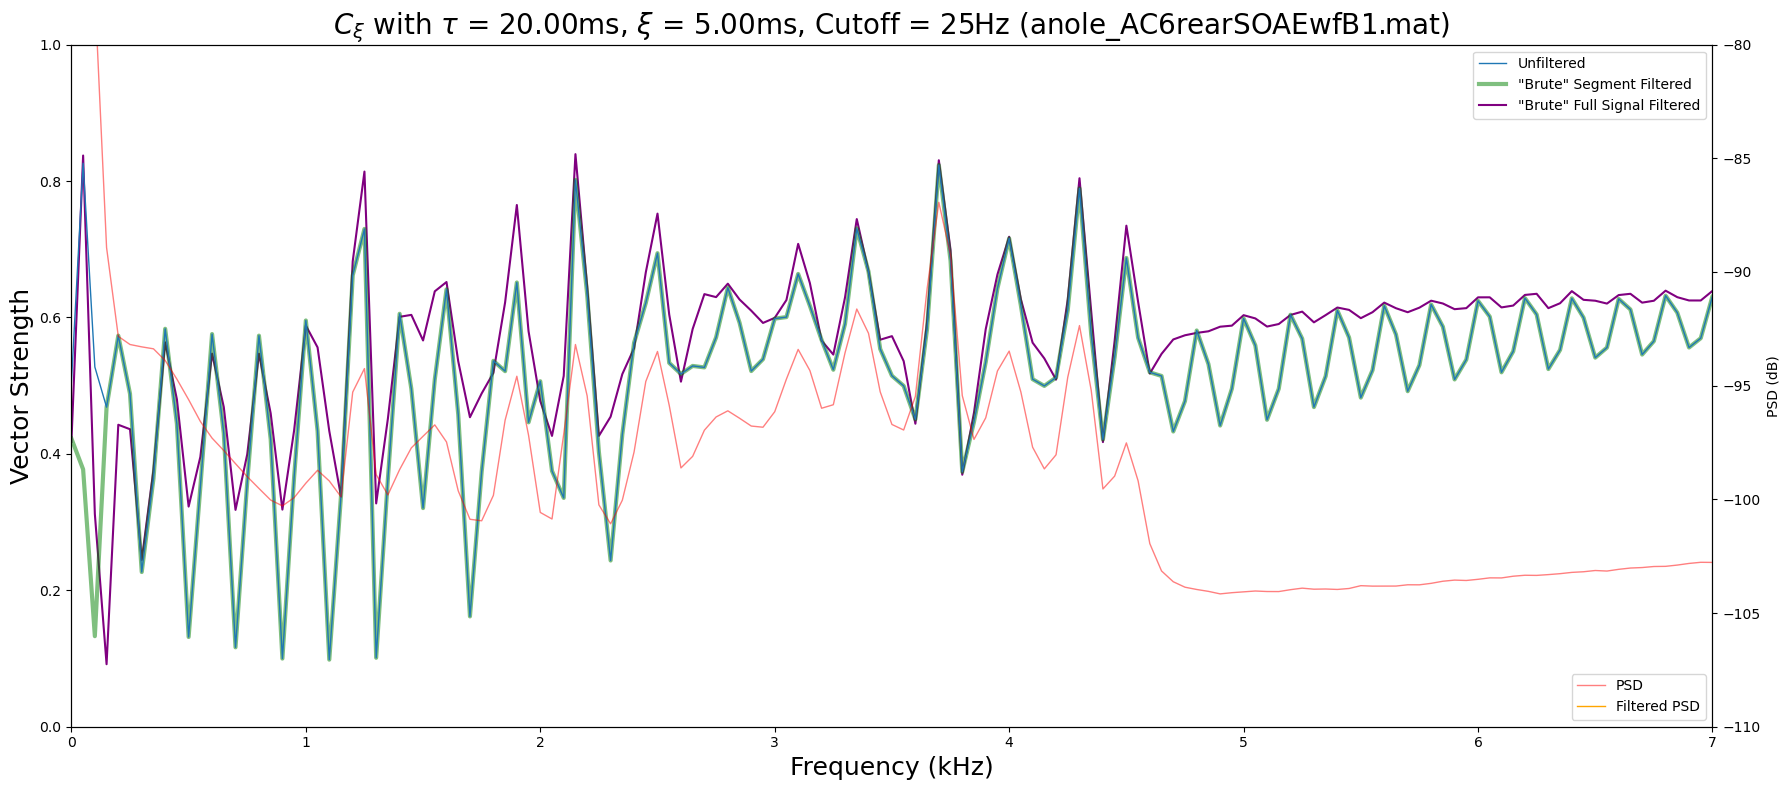

In [ ]:
taus = [20]
xi_s = 5
n_plots = int(len(taus))
plt.figure(figsize=(18, 8*n_plots))
for i, tau_s in enumerate(taus):
    plt.subplot(n_plots, 1, i + 1)
    plot_filter_seg_comparison(tau_s, xi_s, cutoff_freq = 25,filter_plots=False)

plt.tight_layout()
plt.show()

In [ ]:
# Now try filtering seg by seg, I bet it doesn't change the coherence at high freqs anymore!

from scipy.signal import welch

# Calculate coherence
tau_s = 60 / 1000
xi_s = 20 / 1000

fftshift_segs = False
cutoff_freq = 200


def brute_filter(wf, fs, cutoff_freq):
    fft_coefficients = np.fft.rfft(wf)
    frequencies = np.fft.rfftfreq(len(wf), d=1/fs)

    # Zero out coefficients from 0 Hz to cutoff_frequency Hz
    fft_coefficients[frequencies <= cutoff_freq] = 0

    # Compute the inverse real-valued FFT (irfft)
    return np.fft.irfft(fft_coefficients)

f, coherence_brute_filt = get_autocoherence(wf, fs, tau=tau_s, xi=xi_s, ref_type="time", fftshift_segs=fftshift_segs, filter_seg='brute')

f, coherence = get_autocoherence(wf, fs, tau=tau_s, xi=xi_s, ref_type="time", fftshift_segs=fftshift_segs, filter_seg=False)

wf_brute_filt = brute_filter(wf, fs, cutoff_freq)

f, coherence_brute_filt_full_signal = get_autocoherence(wf_brute_filt, fs, tau=tau_s, xi=xi_s, ref_type="time", fftshift_segs=fftshift_segs, filter_seg=False)

f_psd, psd_lizard = welch(wf, fs, nperseg=int(tau_s*fs))
f_psd_brute, psd_lizard_brute = welch(wf_brute_filt, fs, nperseg=int(tau_s*fs))




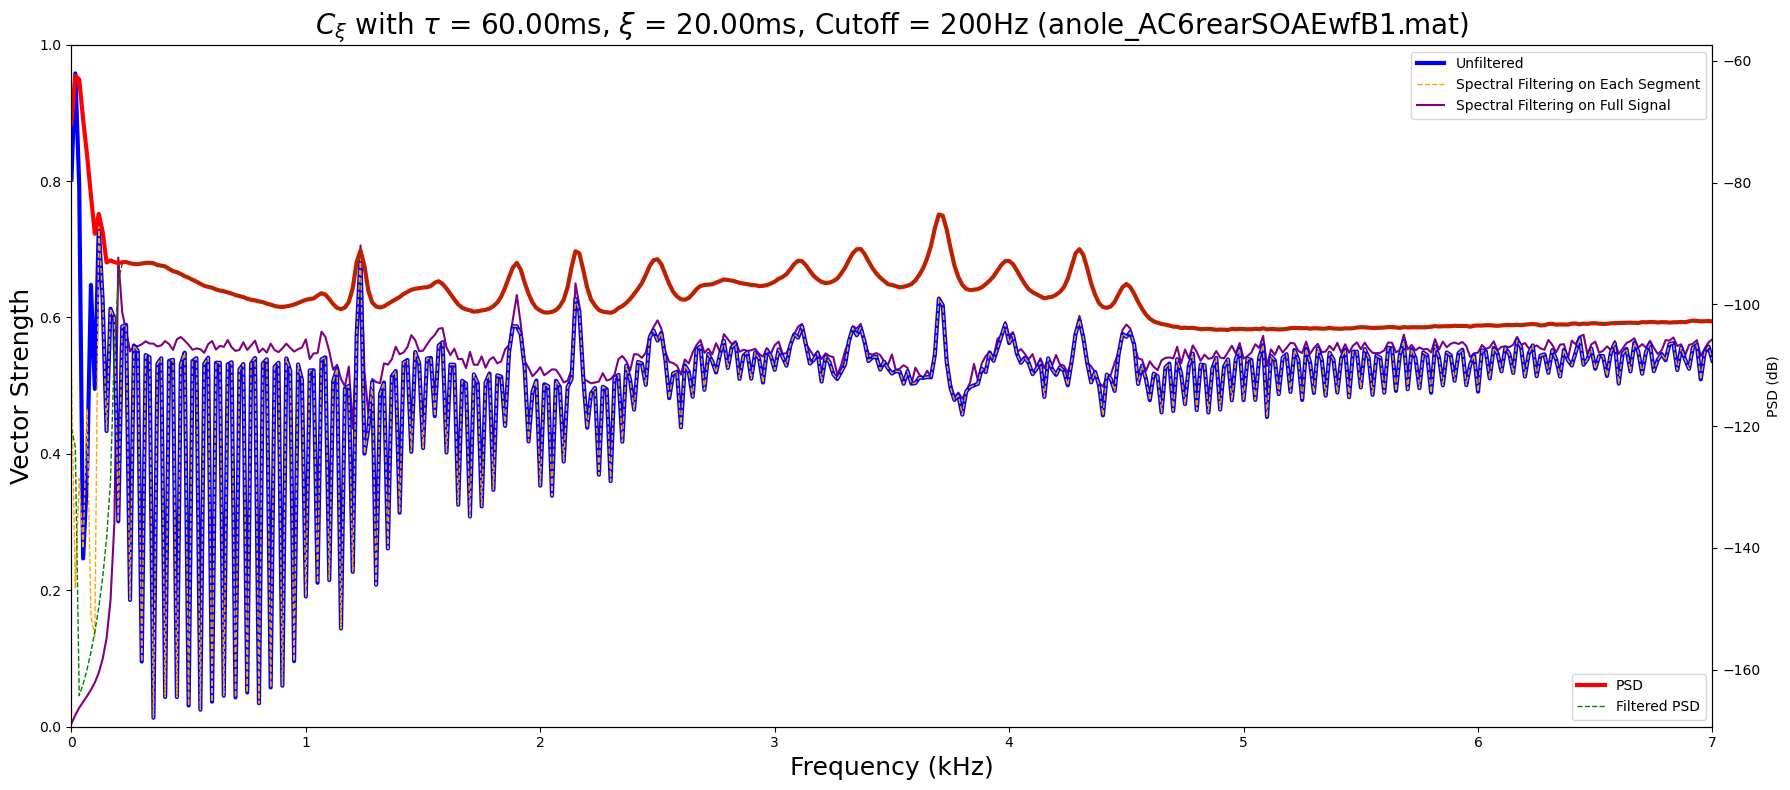

If we only consider bins above the filter cutoff 200Hz
The mean difference in the PSD is:  1.9662217607331702e-13
Whereas the mean amount in each bin unfiltered (for scale reference) is:  8.837696010474631e-11
Whereas the mean amount in each bin filtered (for scale reference) is:  8.818033792867299e-11
If we only consider bins above 5000Hz
The mean difference in the PSD is:  1.0975672884543287e-21
Whereas the mean amount in each bin unfiltered (for scale reference) is:  4.097765885096272e-11
Whereas the mean amount in each bin filtered (for scale reference) is:  4.097765884986516e-11
So quite significant amount of leakage at the upper bins!


In [ ]:
plt.figure(figsize=(18, 8))

ax1=plt.gca()
ax1.set_title(r"$C_{\xi}$ with "+ r"$\tau$ = " + f"{tau_s*1000:.2f}ms, " + r"$\xi$ = " + f"{xi_s*1000:.2f}ms, Cutoff = {cutoff_freq}Hz" + f" ({wf_title})", fontsize=20)
ax1.set_ylabel("Vector Strength", fontsize=18)
ax1.set_xlabel("Frequency (kHz)", fontsize=18)
ax1.plot(f/1000, coherence, label = 'Unfiltered', color='blue', lw=3, alpha = 1, zorder=4)
ax1.plot(f/1000, coherence_brute_filt, label = 'Spectral Filtering on Each Segment', color='orange', ls='--',lw=1, zorder=4, alpha=1)
ax1.plot(f/1000, coherence_brute_filt_full_signal, label = 'Spectral Filtering on Full Signal', color='purple', zorder=1)


ax1.set_ylim(0, 1)
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(f_psd/1000, 10*np.log10(psd_lizard), label ='PSD', color='red', lw=3, alpha=1, zorder=1)
ax2.plot(f_psd_brute/1000, 10*np.log10(psd_lizard_brute), label ='Filtered PSD', color='green', ls='--',lw=1, zorder=2)
ax2.set_ylabel("PSD (dB)")
ax2.legend(loc='lower right')
ax2.set_xlim(0, 7)
# ax2.set_ylim(-110, -80)

plt.tight_layout()
plt.show()

f_cutoff_idx = np.argmin(np.abs(f - cutoff_freq))

print(f"If we only consider bins above the filter cutoff {cutoff_freq}Hz")
print("The mean difference in the PSD is: ", np.mean(psd_lizard[f_cutoff_idx:] - psd_lizard_brute[f_cutoff_idx:]))
print("Whereas the mean amount in each bin unfiltered (for scale reference) is: ", np.mean(psd_lizard[f_cutoff_idx:]))
print("Whereas the mean amount in each bin filtered (for scale reference) is: ", np.mean(psd_lizard_brute[f_cutoff_idx:]))

cutoff_freq2 = 5000
f_cutoff2_idx = np.argmin(np.abs(f - cutoff_freq2))

print(f"If we only consider bins above {cutoff_freq2}Hz")
print("The mean difference in the PSD is: ", np.mean(psd_lizard[f_cutoff2_idx:] - psd_lizard_brute[f_cutoff2_idx:]))
print("Whereas the mean amount in each bin unfiltered (for scale reference) is: ", np.mean(psd_lizard[f_cutoff2_idx:]))
print("Whereas the mean amount in each bin filtered (for scale reference) is: ", np.mean(psd_lizard_brute[f_cutoff2_idx:]))

print("So quite significant amount of leakage at the upper bins!")
